<a href="https://colab.research.google.com/github/jayadevgh/DementiaResearch/blob/main/AlzheimerDataGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Fetch the data
# (a) Download the data
# (b) Show the batch of the images
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


%matplotlib inline

class AlzheimerDataLoader(object):
    def __init__(self, data_path, stats):
        self.data_path = data_path
        self.stats = stats


    def fetch_data(self, dataset_url):
        od.download(dataset_url)

    def denorm(self, img_tensors):
        return img_tensors * self.stats[1][0] + self.stats[0][0]

    def show_images(self, images, labels, num_imgs=64):
        fig, ax = plt.subplots(figsize=(16, 16))
        # plt.xlabel(labels)
        ax.set_xticks(labels);
        ax.set_yticks([])
        ax.imshow(make_grid(self.denorm(images.detach()[:num_imgs]), nrow=8).permute(1, 2, 0), aspect='auto')

    def show_batch(self, data_batch, num_images, num_batches):
        for images, labels in data_batch:
            self.show_images(images, labels, num_images)
            break #showing only num_batches


    def load_data(self, image_sz, batch_sz, train_pct):
        root_dir = os.listdir(self.data_path)[0] #listing directories
        print("root directory", root_dir)
        print("Data directories:")


        # This function does couple of things
        # a) It fetches all the images together with it's lables. Data with different classes is organized
        # by separate folders
        # b) converting image to tensor 4 dimensions: (batch, channel, 64 pixel, 64 pixel)
        # c) It normalizes the data. For example, it can be from -1 to 1

        dataset = ImageFolder(root = self.data_path + "/" + root_dir,
                        transform=T.Compose([
                        T.Resize(image_sz),
                        T.CenterCrop(image_sz),
                        T.ToTensor(), #converting image to tensor 4 dimensions: (batch, channel, 64 pixel, 64 pixel)
                        T.Normalize(*self.stats)]))

        train_size = int(train_pct * len(dataset))
        sizes = [train_size, len(dataset) - train_size]

        # It shuffles the data and gives the train and test datasets based on the given sizes
        # By using the same seed shuffling can always be repeated
        train_ds, test_ds = torch.utils.data.random_split(dataset, sizes, generator=torch.Generator().manual_seed(8192))
        print("train, test classes:", train_ds.dataset.classes, test_ds.dataset.classes)
        print("train, test dataset sz:", len(train_ds), len(test_ds))

        self.train_batch = DataLoader(train_ds, batch_sz, shuffle=True, num_workers=3, pin_memory=True)#gives data in batches by bathc_size

        self.test_batch = DataLoader(test_ds, batch_sz, shuffle=True, num_workers=3, pin_memory=True)#gives data in batches by bathc_size






Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jayghanta
Your Kaggle Key: ··········


100%|██████████| 28.0M/28.0M [00:00<00:00, 158MB/s]

root directory Dataset
Data directories:
train, test classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'] ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
train, test dataset sz: 5120 1280


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


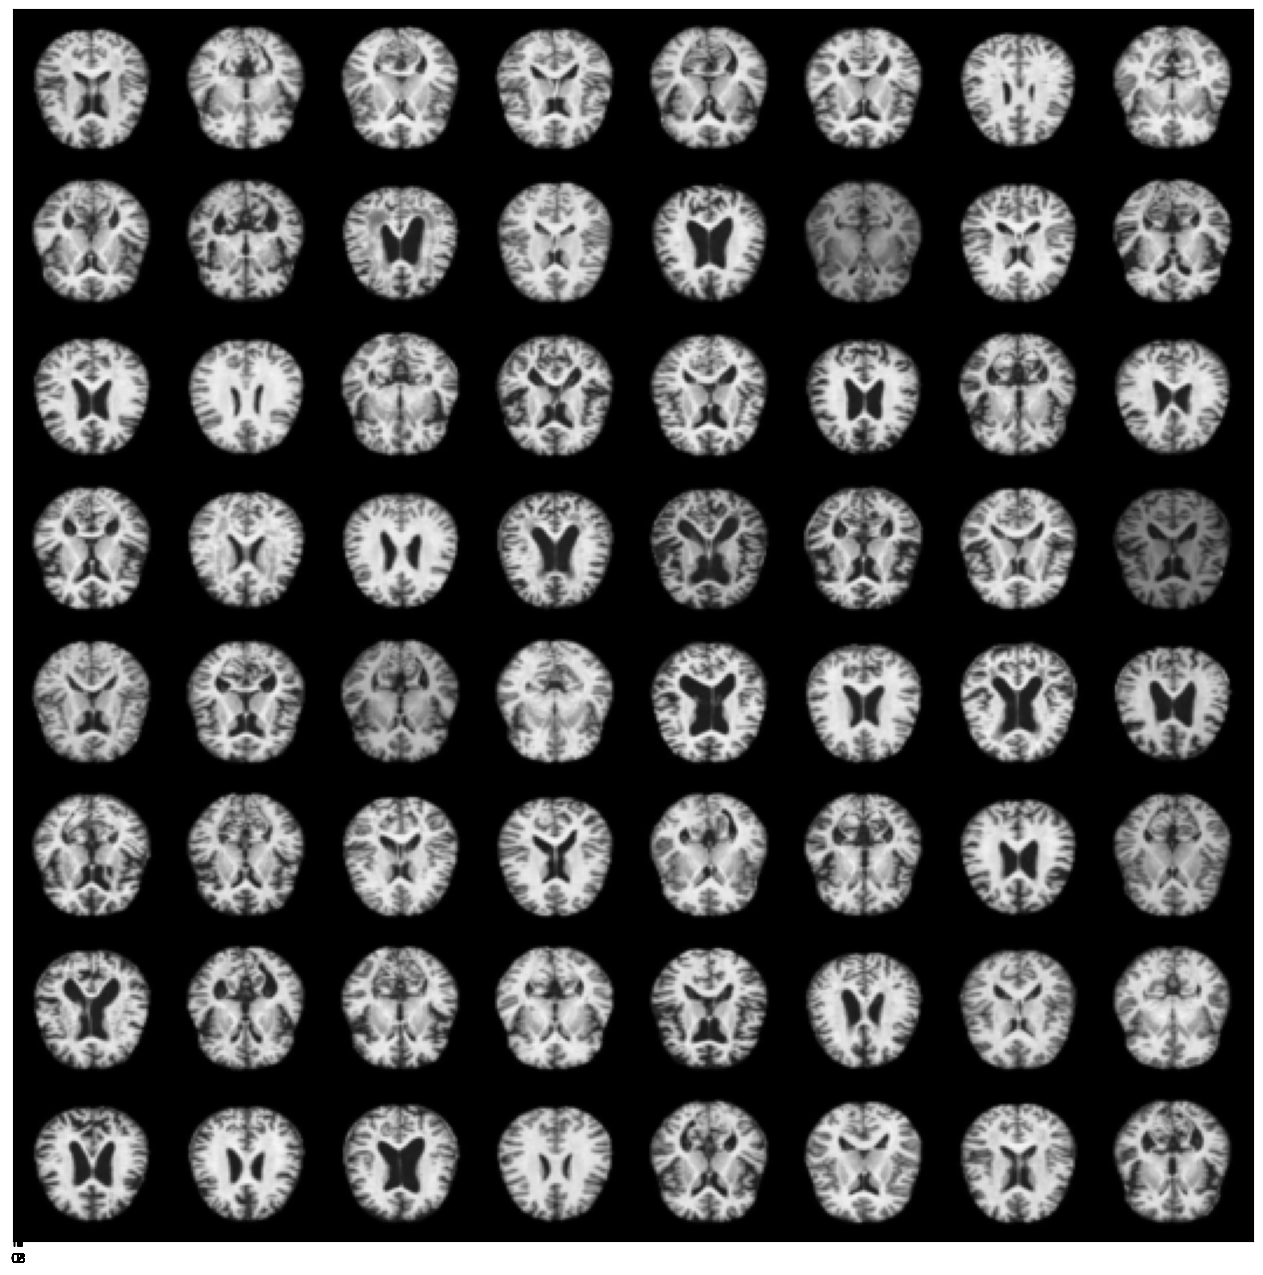

In [2]:
DATASET_URL = 'https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset'
DATA_DIR = 'alzheimer-mri-dataset'

normalize_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Mean and standard deviation for RGB channels
                                                   # Normalize the pixels between -1 and 1
                                                   # Normalize the pixels between 0 and 1

alz_data_loader = AlzheimerDataLoader(DATA_DIR, normalize_stats)

image_sz = 64
batch_sz = 128
train_pct = 0.8
alz_data_loader.fetch_data(DATASET_URL)
alz_data_loader.load_data(image_sz, batch_sz, train_pct)
alz_data_loader.show_batch(alz_data_loader.train_batch, 64, 1)

In [10]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield self.to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

    def to_device(self, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list, tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [11]:
device = get_default_device()
print(device)
dev_train_dl = DeviceDataLoader(alz_data_loader.train_batch, device)
dev_test_dl = DeviceDataLoader(alz_data_loader.test_batch, device)

cuda


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/31],  train loss: 2.0212, train_accuracy: 59.3945
Mean Test loss: 1.3160, test_accuracy: 58.9063


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2/31],  train loss: 1.4025, train_accuracy: 49.5312
Mean Test loss: 0.9594, test_accuracy: 50.5469


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [3/31],  train loss: 0.9532, train_accuracy: 53.3008
Mean Test loss: 0.8701, test_accuracy: 58.2031


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [4/31],  train loss: 0.8891, train_accuracy: 58.2031
Mean Test loss: 0.8751, test_accuracy: 57.5781


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/31],  train loss: 0.8635, train_accuracy: 58.1641
Mean Test loss: 0.8214, test_accuracy: 62.8125


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [6/31],  train loss: 0.9007, train_accuracy: 58.1641
Mean Test loss: 0.8513, test_accuracy: 58.2031


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [7/31],  train loss: 0.8087, train_accuracy: 62.7930
Mean Test loss: 0.7111, test_accuracy: 67.9688


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [8/31],  train loss: 0.7253, train_accuracy: 67.9492
Mean Test loss: 0.6254, test_accuracy: 74.6094


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [9/31],  train loss: 0.7575, train_accuracy: 68.0664
Mean Test loss: 1.1436, test_accuracy: 48.7500


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/31],  train loss: 0.6403, train_accuracy: 73.0273
Mean Test loss: 1.4417, test_accuracy: 39.2188


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [11/31],  train loss: 0.6187, train_accuracy: 74.4141
Mean Test loss: 0.8908, test_accuracy: 55.4688


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [12/31],  train loss: 0.4610, train_accuracy: 82.5781
Mean Test loss: 0.6075, test_accuracy: 75.2344


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [13/31],  train loss: 0.3801, train_accuracy: 86.8359
Mean Test loss: 0.4594, test_accuracy: 81.0156


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [14/31],  train loss: 0.2101, train_accuracy: 92.6367
Mean Test loss: 0.2251, test_accuracy: 92.3438


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/31],  train loss: 0.5263, train_accuracy: 79.4727
Mean Test loss: 0.2615, test_accuracy: 90.7031


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [16/31],  train loss: 0.1465, train_accuracy: 95.3516
Mean Test loss: 0.1458, test_accuracy: 94.4531


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [17/31],  train loss: 0.0147, train_accuracy: 99.6289
Mean Test loss: 0.2186, test_accuracy: 93.1250


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [18/31],  train loss: 0.0804, train_accuracy: 97.4414
Mean Test loss: 0.1977, test_accuracy: 95.0781


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [19/31],  train loss: 0.2667, train_accuracy: 91.1133
Mean Test loss: 0.9887, test_accuracy: 48.7500


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/31],  train loss: 0.6011, train_accuracy: 75.7227
Mean Test loss: 0.1614, test_accuracy: 95.3125


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [21/31],  train loss: 0.1177, train_accuracy: 96.6797
Mean Test loss: 0.1380, test_accuracy: 96.3281


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [22/31],  train loss: 0.0073, train_accuracy: 99.9609
Mean Test loss: 0.1207, test_accuracy: 96.7188


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [23/31],  train loss: 0.0011, train_accuracy: 100.0000
Mean Test loss: 0.1247, test_accuracy: 96.7969


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [24/31],  train loss: 0.0004, train_accuracy: 100.0000
Mean Test loss: 0.1341, test_accuracy: 96.8750


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/31],  train loss: 0.0003, train_accuracy: 100.0000
Mean Test loss: 0.1407, test_accuracy: 96.7969


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [26/31],  train loss: 0.0002, train_accuracy: 100.0000
Mean Test loss: 0.1449, test_accuracy: 96.7969


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [27/31],  train loss: 0.0001, train_accuracy: 100.0000
Mean Test loss: 0.1482, test_accuracy: 96.7969


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [28/31],  train loss: 0.0001, train_accuracy: 100.0000
Mean Test loss: 0.1514, test_accuracy: 96.7969


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [29/31],  train loss: 0.0001, train_accuracy: 100.0000
Mean Test loss: 0.1538, test_accuracy: 96.7969


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30/31],  train loss: 0.0001, train_accuracy: 100.0000
Mean Test loss: 0.1559, test_accuracy: 96.7969


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [31/31],  train loss: 0.0000, train_accuracy: 100.0000
Mean Test loss: 0.1577, test_accuracy: 96.7969


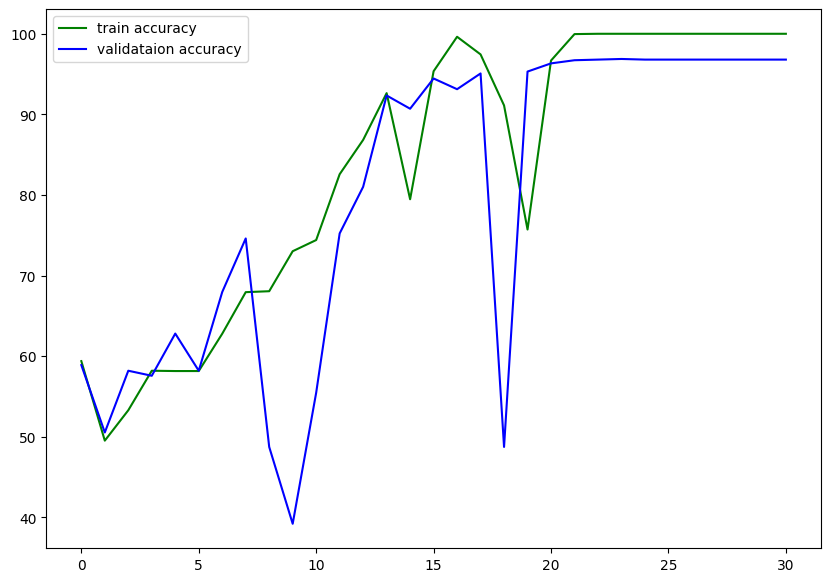

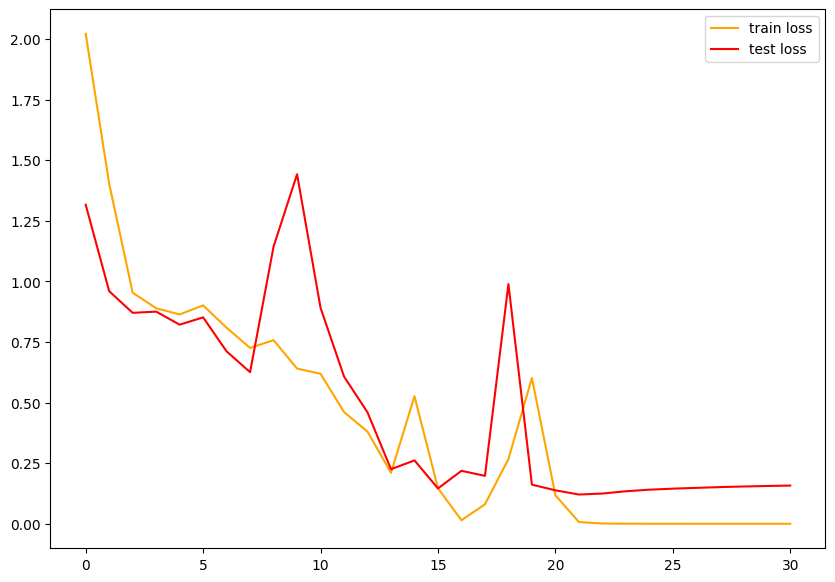

In [16]:
## This class helps in classifying the alzheimer images with different severities.
from torchvision.models import resnet50, ResNet50_Weights, vgg16
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

train_epoch_accuracy = []
test_epoch_accuracy = []
train_epoch_loss = []
test_epoch_loss = []
class AlzheimerImageClassification(object):
    def __init__(self, train_dl, test_dl, device):
        #self.data_loader = data_loader
        self.device = device
        self.train_dl = train_dl
        self.test_dl = test_dl

    def set_pre_trained_model(self, pre_model):
        torch.cuda.empty_cache()
        torch.manual_seed(8192)
        if pre_model == "resnet50":
            self.model = resnet50(pretrained=True)
        else:
            self.model = vgg16(pretrained=True)
        self.model.to(self.device)
        self.model.eval()

    def accuracy(self, out, labels):
        _,pred = torch.max(out, dim=1)
    # print(pred, labels)
        return torch.sum(pred==labels).item()


    def draw_accuracy_plot(self, train_epoch_accuracy, test_epoch_accuracy):
        plt.figure(figsize=(10, 7))
        plt.plot(train_epoch_accuracy, color='green', label='train accuracy')
        plt.plot(test_epoch_accuracy, color='blue', label='validataion accuracy')
        plt.legend()
        plt.savefig('accuracy.png')
        plt.show()

    def draw_loss_plot(self, train_epoch_loss, test_epoch_loss):
        plt.figure(figsize=(10, 7))
        plt.plot(train_epoch_loss, color='orange', label='train loss')
        plt.plot(test_epoch_loss, color='red', label='test loss')
        plt.legend()
        plt.savefig('loss.png')
        plt.show()


    def fit(self, epochs, lr,  start_idx=1, seed=8192):
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 128) #why 128
        self.model.fc = self.model.fc.cuda()




        torch.cuda.empty_cache()
        torch.manual_seed(seed)
        self.model = self.model.to(device)
        self.model.train()

    # Losses & scores


        # Create optimizers
        opt_d = torch.optim.Adam(self.model.parameters(), lr=lr, betas=(0.5, 0.999))


        for epoch in range(epochs):
            train_loss = 0
            train_running_accuracy = 0
            for real_images, labels in tqdm(self.train_dl):
                # Train discriminator
                opt_d.zero_grad()
                real_preds = self.model(real_images)
                real_targets = labels
                # print("real_preds, labels", real_preds, labels)
                #print(real_preds.shape, labels.shape)
                real_loss = F.cross_entropy(real_preds, real_targets)
                real_loss.backward()
                opt_d.step()
                train_loss += real_loss.item()
                sum = self.accuracy(real_preds, real_targets)
                # print("sum", sum)
                train_running_accuracy += sum
                # loss_d = train_discriminator(real_images, labels, opt_d)
            # real_scores.append(real_score)
            mean_train_loss = train_loss / len(self.train_dl)
            # print("train_dl length:", len(train_dl.dl.dataset))
            train_accuracy = 100 * (train_running_accuracy / len(self.train_dl.dl.dataset))
            train_epoch_accuracy.append(train_accuracy)
            train_epoch_loss.append(mean_train_loss)

            with torch.no_grad():
                self.model.eval()
                test_loss = 0
                test_running_accuracy = 0
                for data_t, target_t in tqdm(self.test_dl):
                    real_preds = self.model(data_t)

                    real_targets = target_t
                    loss = F.cross_entropy(real_preds, real_targets)
                    test_loss += loss.item()
                    test_running_accuracy += self.accuracy(real_preds, real_targets)
            mean_test_loss = test_loss / len(self.test_dl)
            test_accuracy = 100 * (test_running_accuracy / len(self.test_dl.dl.dataset))
            test_epoch_accuracy.append(test_accuracy)
            test_epoch_loss.append(mean_test_loss)

            # Log losses & scores (last batch)
            print("Epoch [{}/{}],  train loss: {:.4f}, train_accuracy: {:.4f}".format(
                epoch+1, epochs, mean_train_loss, train_accuracy))
            print("Mean Test loss: {:.4f}, test_accuracy: {:.4f}".format(mean_test_loss, test_accuracy))

            # Save generated images
            # save_samples(dir_idx, epoch+start_idx, fixed_latent, show=False)

        torch.save(self.model, "Alzheimer_Classification_Model")


lr = 0.0001
epochs = 31

alz_classification = AlzheimerImageClassification(dev_train_dl, dev_test_dl, device)
alz_classification.set_pre_trained_model("resnet50")
history = alz_classification.fit(epochs, lr)

alz_classification.draw_accuracy_plot(train_epoch_accuracy, test_epoch_accuracy)
alz_classification.draw_loss_plot(train_epoch_loss, test_epoch_loss)






In [ ]:
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, emb_size=28):
        super(Discriminator, self).__init__()
        self.emb_size = emb_size
        self.label_embeddings = nn.Embedding(4, self.emb_size)
        self.model = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64,64*2,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64*2,64*4,kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64*8,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Flatten()
        )
        self.model2 = nn.Sequential(
            nn.Linear(284,100),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(100,1),
            nn.Sigmoid()
        )

        self.apply(weights_init)
    def forward(self, input, labels):
        x = self.model(input)
        y = self.label_embeddings(labels)
        input = torch.cat([x, y], 1)
        final_output = self.model2(input)
        return final_output

In [ ]:
Here we are implementing a conditional generator. It means generating a specific class of data
class Generator(nn.Module):
    def __init__(self, emb_size=28, num_classes=4):
        super(Generator,self).__init__()
        self.emb_size = emb_size
        self.label_embeddings = nn.Embedding(4, self.emb_size)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100+self.emb_size,64*8,4,1,0,bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input_noise,labels):
        label_embeddings = self.label_embeddings(labels).view(len(labels), self.emb_size, 1, 1)
        input = torch.cat([input_noise, label_embeddings], 1)
        return self.model(input)

In [ ]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(28,3,64,64).to(device), torch.zeros(28).long().to(device));


In [ ]:

generator = Generator().to(device)
summary(generator,torch.zeros(28,100,1,1).to(device), torch.zeros(28).long().to(device));